In [1]:
%matplotlib widget

In [2]:
import argparse
import os
import pickle
import pandas as pd
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.infer.mcmc
import pyro.distributions as dist

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Let's generate data for 18 models, 1000 examples, with a, b, theta, gamma, parameters.
a, b, theta are multiple dimensions.

## Lets define prior distribution

In [3]:
def set_seeds(seed):
    np.random.seed(seed)
    pyro.set_rng_seed(seed)
    torch.manual_seed(seed)

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

In [4]:
seed=42
diff="normal"
discr="lognormal"
guess="normal"
ability="normal"

diff_transform="identity"
discr_transform="identity"
guess_transform="identity"
ability_transform="identity"

alpha_std=1
item_param_std=1
dimension=3


dist_type="multivariate"

In [5]:
set_seeds(seed)

# defining dataset sizes
n_models, n_items = 18, 3000
dimension=3

In [8]:

dist_mean = 0
theta_dist = {"mu": dist_mean, "std": item_param_std}


# define distribution parameters
alpha_dist = {"mu": dist_mean, "std": alpha_std}


positive_transform = lambda x: torch.log(1 + torch.exp(x))

log_gamma = pyro.sample("log c", dist.Normal(dist_mean * torch.ones(n_items), item_param_std))
gamma = sigmoid(log_gamma)

# Generate params
if dist_type != "multivariate":
    betas = pyro.sample("b", dist.Normal(dist_mean * torch.ones(n_items, dimension), item_param_std))

    alphas = pyro.sample("a",
            dist.LogNormal(
                alpha_dist["mu"] * torch.ones(n_items, dimension),
                alpha_dist["std"],
            ),
        )

    # Generate thetas
    thetas = pyro.sample(
            "theta",
            dist.Normal(
                theta_dist["mu"] * torch.ones(n_models, dimension),
                theta_dist["std"],
            ),
        )
else:
    dist_mean_b = torch.FloatTensor([0, 1, 5])
    cov_mat_b = torch.FloatTensor([[5, 0, 0], [0, 2, 0], [0, 0, 4]])
    betas = pyro.sample(
        "b",
        dist.MultivariateNormal(
            torch.vstack(n_items * [dist_mean_b]),
            covariance_matrix= torch.stack([cov_mat_b] * n_items))
    )

    dist_mean_a = torch.FloatTensor([10, 5, 8])
    cov_mat_a = torch.FloatTensor([[3, 0, 0], [0, 4, 0], [0, 0, 6]])
    alphas = pyro.sample(
        "a",
        dist.MultivariateNormal(
            torch.vstack(n_items * [dist_mean_a]),
            covariance_matrix= torch.stack([cov_mat_a] * n_items))
    )

    thetas = pyro.sample(
        "theta",
        dist.MultivariateNormal(
            torch.vstack(n_models * [dist_mean_b]),
            covariance_matrix= torch.stack([cov_mat_b] * n_models))
    )


if dimension > 1:
    probs = gamma[None, :]  + (1.0 - gamma[None, :])   * sigmoid( 1./np.sqrt(dimension) * torch.sum(alphas[None, :, :] * (thetas[:, None] - betas[None, :]).squeeze(), dim=-1))
else:
    probs = gamma[None, :] + (1.0 - gamma[None, :]) * sigmoid(alphas[None, :] * (thetas[:, None] - betas[None, :]))
lik = dist.Bernoulli(probs).sample()



model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = [f"data_d{dimension}_mean{dist_mean}_a{alpha_std:.2f}_t{item_param_std:.2f}_{i}" for i in range(n_items)]

df = pd.DataFrame(data=lik.numpy().astype(int),
                  index=model_names,
                  columns=items_names)
df.index.names = ['userid']

param_dict = {
        "a": alphas.numpy(),
        "b": betas.numpy(),
        "g": gamma.numpy(),
        "t": thetas.numpy(),
        "probs": probs.numpy()
}
#with open(os.path.join(response_dir, f'params_sync_dim{dimension}_mean{dist_mean}_alpha-{discr}-{alpha_std:.2f}_theta-{ability}-{item_param_std:.2f}_irt_all_coded.p'), 'wb') as handle:
#    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#response_output=os.path.join(response_dir, f'sync_dim{dimension}_mean{dist_mean}_alpha-{discr}-{alpha_std:.2f}_theta-{ability}-{item_param_std:.2f}_irt_all_coded.csv')
#df.to_csv(response_output)
   

In [9]:
log_gamma2 = pyro.sample("log c2", dist.Normal((dist_mean + 4) * torch.ones(n_items), item_param_std))
gamma2 = sigmoid(log_gamma2)

dist_mean_a2 = torch.FloatTensor([20, 15, 18])
cov_mat_a2 = torch.FloatTensor([[3, 0, 0], [ 0, 5, 0], [0, 0, 8]])
alphas2 = pyro.sample(
    "a2",
    dist.MultivariateNormal(
        torch.vstack(n_items * [dist_mean_a2]),
        covariance_matrix= torch.stack([cov_mat_a2] * n_items))
)

dist_mean_b2 = torch.FloatTensor([5, 6, 11])
cov_mat_b2 = torch.FloatTensor([[7, 0, 0], [0, 4, 0], [0, 0, 9]])
betas2 = pyro.sample(
    "b2",
    dist.MultivariateNormal(
        torch.vstack(n_items * [dist_mean_b2]),
        covariance_matrix= torch.stack([cov_mat_b2] * n_items)))

   
thetas2 = pyro.sample(
    "theta2",
    dist.MultivariateNormal(
        torch.vstack(n_models * [dist_mean_b2]),
        covariance_matrix= torch.stack([cov_mat_b2] * n_models))
)
probs2 = gamma2[None, :]  + (1.0 - gamma2[None, :])   * sigmoid( 1./np.sqrt(dimension) * torch.sum(alphas2[None, :, :] * (thetas2[:, None] - betas2[None, :]).squeeze(), dim=-1))
lik2 = dist.Bernoulli(probs).sample()


In [10]:
param_dict = {
        "a": alphas.numpy(),
        "b": betas.numpy(),
        "g": gamma.numpy(),
        "t": thetas.numpy(),
        "probs": probs.numpy(),
        "a2": alphas2.numpy(),
        "b2": betas2.numpy(),
        "g2": gamma2.numpy(),
        "t2": thetas2.numpy(),
        "probs2": probs2.numpy()
}


In [11]:
param_dict

{'a': array([[13.821904 ,  6.841589 ,  7.6703978],
        [10.828441 ,  6.729497 ,  4.6667995],
        [ 6.8930283,  7.523129 ,  8.133355 ],
        ...,
        [ 6.416501 ,  1.4595969, 11.107408 ],
        [ 8.564127 ,  4.772763 ,  6.217797 ],
        [ 9.449933 ,  2.290978 , 11.686506 ]], dtype=float32),
 'b': array([[-2.3571594 , -2.270505  ,  3.194539  ],
        [-3.1720743 ,  1.5338812 ,  4.581357  ],
        [ 3.9370873 ,  0.2063632 ,  3.1631358 ],
        ...,
        [ 0.7250322 , -0.0186398 ,  6.1281357 ],
        [ 0.55412227,  0.7778709 ,  5.641215  ],
        [ 2.5471814 ,  0.14309692,  3.4053526 ]], dtype=float32),
 'g': array([0.8729076 , 0.8156703 , 0.7110969 , ..., 0.491427  , 0.3622701 ,
        0.60820574], dtype=float32),
 't': array([[-2.4280531 ,  2.6301074 ,  7.1095095 ],
        [ 2.1063647 ,  0.3586946 ,  5.5017495 ],
        [-0.0114193 , -1.5420339 ,  7.0220995 ],
        [ 1.7437507 , -0.39239192,  5.492729  ],
        [-0.63874865,  0.83659756,  6.251174

In [12]:
response_dir="/Users/phumon/Documents/Research/nlu-mirt/data_sync/dim3_mnormal_ndist2"

In [13]:
with open("params_dim3_mnormal_ndist2.p", 'wb') as handle:
    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Populating the interactive namespace from numpy and matplotlib


/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed', 'gamma', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


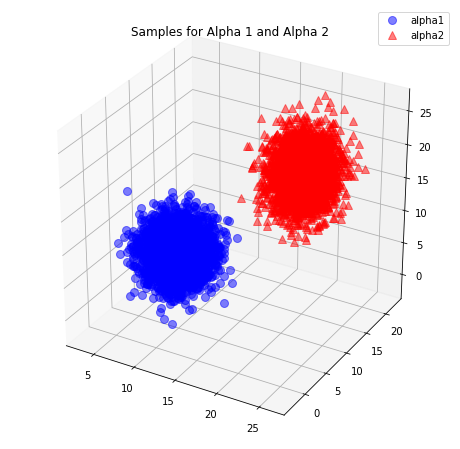

In [14]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(alphas.T[0,:], alphas.T[1,:], alphas.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='alpha1')
ax.plot(alphas2.T[0,:], alphas2.T[1,:], alphas2.T[2,:], '^', markersize=8, color='red', alpha=0.5, label='alpha2')

plt.title('Samples for Alpha 1 and Alpha 2')
ax.legend(loc='upper right')

plt.show()

/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


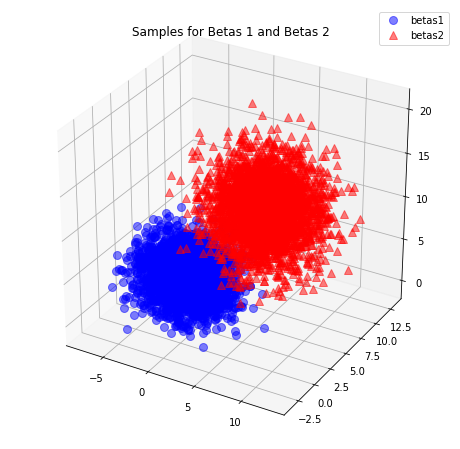

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(betas.T[0,:], betas.T[1,:], betas.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='betas1')
ax.plot(betas2.T[0,:], betas2.T[1,:], betas2.T[2,:], '^', markersize=8, color='red', alpha=0.5, label='betas2')

plt.title('Samples for Betas 1 and Betas 2')
ax.legend(loc='upper right')

plt.show()

/Users/phumon/opt/anaconda3/envs/latent_features/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


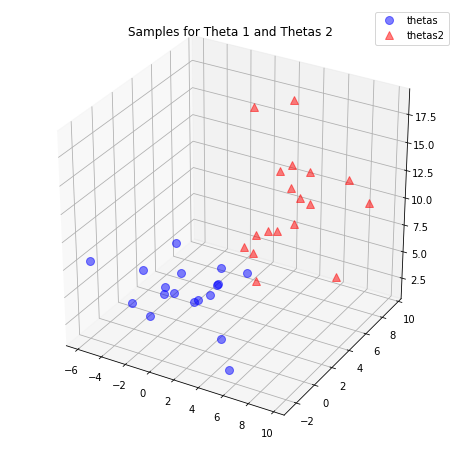

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(thetas.T[0,:], thetas.T[1,:], thetas.T[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='thetas')
ax.plot(thetas2.T[0,:], thetas2.T[1,:], thetas2.T[2,:], '^', markersize=8, color='red', alpha=0.5, label='thetas2')

plt.title('Samples for Theta 1 and Thetas 2')
ax.legend(loc='upper right')

plt.show()

# Samplin from distributions

In [19]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names_dist1 = [f"data_dist1_{i}" for i in range(n_items)]
items_names_dist2 = [f"data_dist2_{i}" for i in range(n_items)]

#with open(os.path.join(response_dir, f'params_sync_dim{dimension}_mean{dist_mean}_alpha-{discr}-{alpha_std:.2f}_theta-{ability}-{item_param_std:.2f}_irt_all_coded.p'), 'wb') as handle:
#    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)



for i in range(50):
    lik_dist1 = dist.Bernoulli(probs).sample()
    lik_dist2 = dist.Bernoulli(probs2).sample()
    
    df1 = pd.DataFrame(data=lik_dist1.numpy().astype(int),
                  index=model_names,
                  columns=items_names_dist1)
    df1.index.names = ['userid']
    df2 = pd.DataFrame(data=lik_dist2.numpy().astype(int),
                  index=model_names,
                  columns=items_names_dist2)
    df2.index.names = ['userid']
    
    response_output1=os.path.join(response_dir, f'dist1_version{i}_irt_all_coded.csv')
    df1.to_csv(response_output1)
    
    response_output2=os.path.join(response_dir, f'dist2_version{i}_irt_all_coded.csv')
    df2.to_csv(response_output2)

    


# For Multivariate Nomal

# For 1D

In [ ]:
# Generate betas
betas = pyro.sample("b", dist.Normal(torch.zeros(n_items), item_params_std))

# Generate gamma
log_gamma = pyro.sample("log c", dist.Normal(torch.zeros(n_items), item_params_std))
gamma = sigmoid(log_gamma)

# Generate alphas
alphas = pyro.sample(
            "a",
            dist.LogNormal(
                alpha_dist["mu"] * torch.ones(n_items),
                alpha_dist["std"],
            ),
        )

# Generate thetas
thetas = pyro.sample(
            "theta",
            dist.Normal(
                theta_dist["mu"] * torch.ones(n_models),
                theta_dist["std"],
            ),
        )

#alphas = positive_transform(alphas)
#thetas = positive_transform(thetas)
lik = dist.Bernoulli(
            gamma[None, :]
            + (1.0 - gamma[None, :])
            * sigmoid(alphas[None, :] * (thetas[:, None] - betas[None, :]))
        ).sample()
    
    
responses=lik

In [ ]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = ["data_{}".format(i) for i in range(n_items)]

df = pd.DataFrame(data = responses.numpy().astype(int),  
                        index = model_names,  
                        columns = items_names) 
df.index.names = ['userid']
df
#df.to_csv('/Users/phumon/Documents/Research/nlu-test-sets/data_synthetic/sync_irt_all_coded.csv')

# Multiple Dim

In [ ]:
n_models, n_items = 18, 1000
dimension=6
item_params_std=1

alpha_dist={}
alpha_dist = {"mu": 0.0, "std":0.3}
theta_dist = {"mu": 0.0, "std":1}

positive_transform = lambda x: torch.log(1 + torch.exp(x))


In [ ]:
# Generate betas
betas = pyro.sample("b", dist.Normal(torch.zeros(n_items, dimension), item_params_std))

# Generate gamma
log_gamma = pyro.sample("log c", dist.Normal(torch.zeros(n_items), item_params_std))
gamma = sigmoid(log_gamma)

# Generate alphas
alphas = pyro.sample(
            "a",
            dist.LogNormal(
                alpha_dist["mu"] * torch.ones(n_items, dimension),
                alpha_dist["std"],
            ),
        )

# Generate thetas
thetas = pyro.sample(
            "theta",
            dist.Normal(
                theta_dist["mu"] * torch.ones(n_models, dimension),
                theta_dist["std"],
            ),
        )

#alphas = positive_transform(alphas)
#thetas = positive_transform(thetas)
if dimension > 1:
    lik = pyro.sample(
            "likelihood",
            dist.Bernoulli(
                gamma[None, :]
                + (1.0 - gamma[None, :])
                * sigmoid(
                    torch.sum(alphas[None, :, :] * (thetas[:, None] - betas[None, :]).squeeze(), dim=-1)  
                )
            )
        )

    
responses=lik

In [ ]:
betas

In [ ]:
model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = ["data_{}".format(i) for i in range(n_items)]

df = pd.DataFrame(data = responses.numpy().astype(int),  
                        index = model_names,  
                        columns = items_names) 
df.index.names = ['userid']
df


In [ ]:
df.to_csv('/Users/phumon/Documents/Research/nlu-test-sets/data_synthetic/dim6/sync_irt_all_coded.csv')

# Load trained params

In [ ]:
repo = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

In [ ]:
def get_stats_CI(params, p=0.95, dist='normal'):
    '''
    Method to calculate lower and upper quantiles defined by `p`, mean, and variance of `param`
    
    Args:
        params: Dictionary of distribution parameters for each item keyed according to the 
                parametric distribution defined by `dist`.
        p:      Percent of distribution covered by the lower and upper interval values for each
                parameter.
        dist:   Name of parametric distribution
    
    Returns:
        return: {
            'lower': Lower interval values of each parameter,
            'upper': Upper interval values of each parameter,
            'mean' : Mean of each parameter,
            'var'  : Variance of each parameter
        }
    '''
    stats = {}
    if dist == 'normal':
        L,U = scipy.stats.norm.interval(p,loc=params['mu'], scale=torch.exp(params['logstd']))
        M,V = scipy.stats.norm.stats(loc=params['mu'], scale=torch.exp(params['logstd']))
    elif dist == 'log-normal':
        L,U = scipy.stats.lognorm.interval(p, s=torch.exp(params['logstd']), scale=torch.exp(params['mu']))
        M,V = scipy.stats.lognorm.stats(s=torch.exp(params['logstd']), scale=torch.exp(params['mu']))
    elif dist == 'beta':
        L,U = scipy.stats.beta.interval(p,a=params['alpha'], b=params['beta'])
        M,V = scipy.stats.beta.stats(a=params['alpha'], b=params['beta'])
    else:
        raise TypeError(f'Distribution type {dist} not supported.')
    
    return {
        'lower':[L],
        'upper':[U],
        'mean':[M],
        'var':[V],
    }

In [ ]:
def get_plot_stats(exp_dir, alpha_dist, theta_dist, transforms, p = 0.95):
    '''
    Method to return plotting statistics for 3 parameter IRT model parameters.
    
    Args:
        exp_dir:          Path to 3 parameter IRT parameters and responses.
        alpha_dist:       Name of the item discrimination [a] distribution.
        theta_dist:       Name of the responder ability [t] distribution.
        transforms:       Dictionary of transformations to apply to each parameter type
                          where keys are parameter names and values are functions.
        p:                Percent of distribution covered by the lower and upper interval 
                          values for each parameter.
    
    Returns:
        param_plot_stats: Dictionary of parameter plot statistics where keys are parameter
                          names and values are plot statistics dictionaries as defined by
                          get_stats_CI().
    '''
    param_dists = {
        'a':alpha_dist,
        'b':'normal',
        'g':'normal',
        't':theta_dist,
    }

    dist_params = {
        'normal':['mu', 'logstd'],
        'log-normal':['mu', 'logstd'],
        'beta':['alpha', 'beta'],
    }

    pyro.clear_param_store()
    pyro.get_param_store().load(os.path.join(exp_dir, 'params.p'))

    with torch.no_grad():
        pyro_param_dict = dict(pyro.get_param_store().named_parameters())
    
    # get stats for plotting
    param_plot_stats = {}

    for param, param_dist in param_dists.items():
        temp_params = dist_params[param_dist]

        for idx, (p1_orig, p2_orig) in enumerate(zip(pyro_param_dict[f'{param} {temp_params[0]}'], pyro_param_dict[f'{param} {temp_params[1]}'])):
            p1, p2 = p1_orig.detach(), p2_orig.detach()
            
            temp_stats_df = pd.DataFrame.from_dict(
                get_stats_CI(
                    params = {
                        temp_params[0]:p1,
                        temp_params[1]:p2,
                    },
                    p=p,
                    dist = param_dist,
                )
            )
            
            temp_stats_df = temp_stats_df.applymap(transforms[param])
        
            if idx == 0:
                param_plot_stats[param] = temp_stats_df
            else:
                param_plot_stats[param] = param_plot_stats[param].append(temp_stats_df, ignore_index = True)
    
    return param_plot_stats

In [ ]:
# distribution and transformation
alpha_dist = 'log-normal'
alpha_transf = 'standard'
theta_dist = 'normal'
theta_transf = 'standard'

exp_dir = os.path.join(repo, 'params_sync_d6_lr1e-3', f'alpha-lognormal-identity-dim6_theta-normal-identity_nosubsample_1.00_0.25')
p = 0.95


select_ts = {
    'standard':lambda x:x,
    'positive':lambda x:torch.log(1+torch.exp(torch.tensor(x))),
    'sigmoid':lambda x:sigmoid(torch.tensor(x)),
}

transforms = {
    'a':select_ts[alpha_transf],
    'b':select_ts['standard'],
    'g':select_ts['sigmoid'],
    't':select_ts[theta_transf],
}


param_plot_stats = get_plot_stats(
    exp_dir,
    alpha_dist,
    theta_dist,
    transforms,
    p = 0.95
)
    


In [ ]:
predicted_mean_b = np.vstack(param_plot_stats['b']['mean'])
predicted_lower_b = np.vstack(param_plot_stats['b']['lower'])
predicted_upper_b = np.vstack(param_plot_stats['b']['upper'])

In [ ]:
predicted_mean_b[0]

In [ ]:
predicted_upper_b[0]

In [ ]:
betas.numpy()

In [ ]:
count=0
for row in np.greater(predicted_upper_b,betas.numpy()).astype(int):
    if 0 in row:
        print(row)
        count += 1
print(count/betas.size(0))